# Bottle Cap Color Detection – Quick Experiments Notebook

Notebook ini berisi eksperimen singkat :
- cek dataset
- relabel warna (light blue / dark blue / others)
- training YOLOv8n
- evaluasi cepat
- cek inference speed di CPU laptop (i7-7500U)


In [45]:
from pathlib import Path
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
import random
from ultralytics import YOLO
import time

from bsort.config import load_config

cfg = load_config(Path("../settings.yaml"))
cfg


AppConfig(dataset=DatasetConfig(train_images='data/train/images', train_labels='data/train/labels', val_images='data/val/images', val_labels='data/val/labels', num_classes=3), training=TrainingConfig(epochs=120, batch_size=16, img_size=480, learning_rate=0.0005, device='cpu'), model=ModelConfig(name='yolov8n', pretrained_weights='yolov8n.pt', output_dir='artifacts', best_model_path='artifacts/bsort_train/weights/best.pt'), inference=InferenceConfig(conf_threshold=0.2, iou_threshold=0.45, output_dir='outputs'), wandb=WandbConfig(enabled=False, project='bottlecap-sorter', entity='your_wandb_username'))

(np.float64(-0.5), np.float64(799.5), np.float64(997.5), np.float64(-0.5))

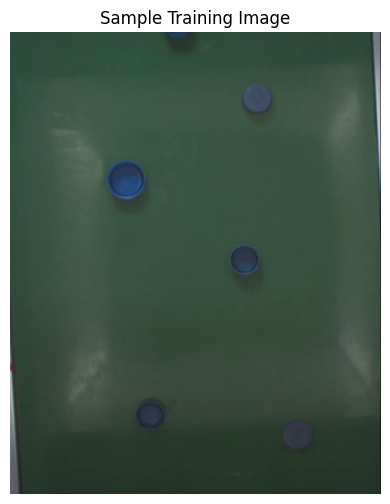

In [46]:

project_root = Path("..").resolve()
train_dir = project_root / cfg.dataset.train_images
img_path = random.choice(glob.glob(str(train_dir / "*.jpg")))
img = cv2.imread(img_path)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Sample Training Image")
plt.axis("off")


## Color Relabel (HSV)
Saya memakai fungsi relabel warna yang saya buat sendiri berdasarkan median HSV di area tengah objek.

Tujuannya:
- menghindari noise background
- mendeteksi 3 kelas: light_blue (0), dark_blue (1), others (2)
- threshold dibuat berdasarkan distribusi warna dataset

Hue biru biasanya di rentang **80–140**, dan saya juga filter dengan Saturation untuk menghindari warna pudar / putih.



In [47]:
import numpy as np
import cv2

def decide_color_label(crop_bgr: np.ndarray) -> int:
    """Decide class id (0/1/2) based on average HSV of the crop.

    0 = light_blue
    1 = dark_blue
    2 = others
    """
    if crop_bgr.size == 0:
        return 2  # fallback aman

    crop_hsv = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(crop_hsv)

    # Ambil area tengah (50%) supaya tidak kena background
    h_center = h[h.shape[0]//4 : 3*h.shape[0]//4,
                h.shape[1]//4 : 3*h.shape[1]//4]

    s_center = s[h.shape[0]//4 : 3*h.shape[0]//4,
                h.shape[1]//4 : 3*h.shape[1]//4]

    v_center = v[h.shape[0]//4 : 3*h.shape[0]//4,
                h.shape[1]//4 : 3*h.shape[1]//4]

    h_mean = float(np.median(h_center))
    s_mean = float(np.median(s_center))
    v_mean = float(np.median(v_center))

    # Rentang hue biru sekitar 80–140
    is_blue_hue = 80 <= h_mean <= 140
    is_saturated = s_mean >= 50

    if is_blue_hue and is_saturated:
        # value tinggi → light blue
        if v_mean >= 100:
            return 0  # light_blue
        else:
            return 1  # dark_blue
    else:
        return 2  # others

# Tes cepat
print("Contoh klasifikasi warna:", decide_color_label(img))


Contoh klasifikasi warna: 2


## Training YOLOv8n (ringkas)
Training dijalankan lewat CLI:

Model disimpan di folder `artifacts/`.


In [48]:
best_model_dir = project_root / cfg.model.best_model_path
model = YOLO(best_model_dir)
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s


image 1/1 E:\Suirfan\ML_Projects\ada-mata-bsort\data\train\images\raw-250110_dc_s001_b5_5.jpg: 480x416 5 dark_blues, 365.1ms
Speed: 73.3ms preprocess, 365.1ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 416)


(np.float64(-0.5), np.float64(799.5), np.float64(997.5), np.float64(-0.5))

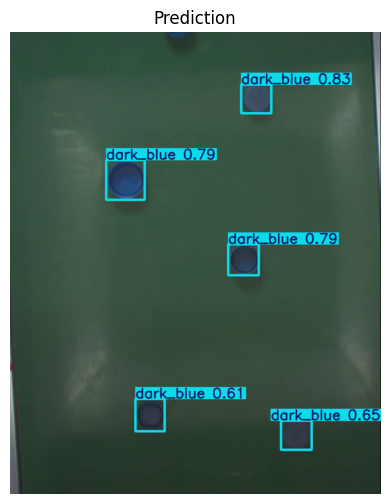

In [49]:
res = model(img_path)
plot = res[0].plot()

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(plot, cv2.COLOR_BGR2RGB))
plt.title("Prediction")
plt.axis("off")


## Inference Speed (CPU Only)

Laptop saya:
- i7-7500U
- 8GB RAM
- inference pakai CPU

Hasil speed test:
- ~51.40 ms/frame  
- ~19.45 FPS


In [ ]:
# tes speed 
N = 3
start = time.time()
for _ in range(N):
    _ = model.predict(img, imgsz=320)
end = time.time()

avg_ms = (end - start) / N * 1000
fps = 1000 / avg_ms

avg_ms, fps



0: 320x288 5 dark_blues, 98.2ms
Speed: 5.6ms preprocess, 98.2ms inference, 2.3ms postprocess per image at shape (1, 3, 320, 288)

0: 320x288 5 dark_blues, 67.8ms
Speed: 1.6ms preprocess, 67.8ms inference, 2.1ms postprocess per image at shape (1, 3, 320, 288)

0: 320x288 5 dark_blues, 99.5ms
Speed: 1.5ms preprocess, 99.5ms inference, 2.4ms postprocess per image at shape (1, 3, 320, 288)


(99.11354382832845, 10.089438449825481)

## Catatan & Limitasi

- HSV threshold simple → sensitif pencahayaan.
- YOLOv8n cukup cepat untuk CPU, tapi masih 51ms di laptop saya.
- Dataset warna biru agak tricky (light vs dark).
